In [14]:
import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
from scipy import stats

In [2]:
# 観測データ
y = jnp.array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=float)

# モデルの定義
def model(y):
    # 事前分布のパラメータ
    alpha = jnp.array(1.0)
    beta = jnp.array(1.0)

    # 推論対象とするパラメータの事前分布
    theta = numpyro.sample("theta", numpyro.distributions.Beta(alpha, beta))

    # 観測データの数だけ生成
    with numpyro.plate("sample", len(y)):
        # 尤度関数
        numpyro.sample("obs", numpyro.distributions.Bernoulli(theta), obs=y)

In [3]:
# NUTS を指定
kernel = numpyro.infer.NUTS(model)

# MCMC の設定
# Apple Silicon では chain に従って並列処理をしてくれなさそう (https://github.com/google/jax/issues/8074)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=3)

/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_81677/525112553.py:5: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=3)


In [6]:
mcmc.run(jax.random.PRNGKey(seed=1), y=y)

sample: 100%|██████████| 2500/2500 [00:01<00:00, 1864.03it/s, 1 steps of size 7.88e-01. acc. prob=0.93]


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

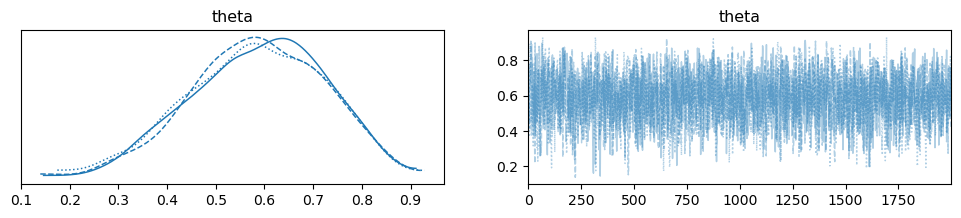

In [8]:
az.plot_trace(mcmc)

In [12]:
for var_info in az.rhat(mcmc).values():
    print(var_info.name, var_info.values.round(4), sep=" ")

theta 1.0001


mcmc sample mean: 0.586
mcmc sample std: 0.138
true posterior mean: 0.583
true posterior std: 0.137


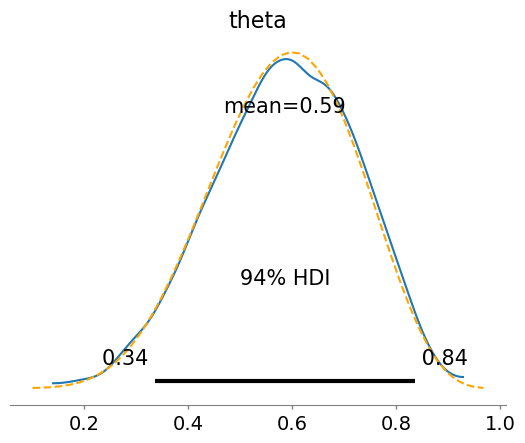

In [16]:
# MCMC サンプルを取得
samples = mcmc.get_samples()

# MCMC サンプルの可視化
ax = az.plot_posterior(samples)

x_lin = np.linspace(*ax.get_xlim())

# 真の事後分布
true_posterior = stats.beta(1 + float(np.sum(y)), 1 + 10 - float(np.sum(y)))

# 真の事後分布の可視化
ax.plot(x_lin, true_posterior.pdf(x_lin), ls="--", color="orange")

print("mcmc sample mean: {:.3f}".format(samples["theta"].mean()))
print("mcmc sample std: {:.3f}".format(samples["theta"].std()))
print("true posterior mean: {:.3f}".format(true_posterior.mean()))
print("true posterior std: {:.3f}".format(true_posterior.std()))